# **Stereo Triangulation YoloV8 output**
***

In [1]:
import numpy as np
import cv2
from ultralytics import YOLO
import torch
import yolov8_postprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time

***
**Laden der Bilder**

In [2]:
img1 = r"/home/mo/Thesis/1.png"
img2 = r"/home/mo/Thesis/2.png"

In [3]:
inp1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
inp2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)

inp1 = cv2.cvtColor(inp1, cv2.COLOR_GRAY2BGR)
inp2 = cv2.cvtColor(inp2, cv2.COLOR_GRAY2BGR)

***
**Inferenz**

In [4]:
model_path = r"/home/mo/YoloV8_InstanceSeg/runs/train/nano/full_set/20250119_1052/weights/best.pt"

model = YOLO(model_path)
print("Model loaded!") if model is not None else print("ERROR - Model not loaded!")

use_gpu = True

if use_gpu and torch.cuda.is_available():
    device = "cuda"
    print("Using GPU!\n\n")
    !nvidia-smi
else:
    device = "cpu"
    print("Using CPU!")

Model loaded!
Using CPU!


/home/mo/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
confidence_threshold = 0.4

def inf(inp, model):
    return model.predict(source = inp,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            # max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)

In [6]:
out1 = inf(inp1, model)
out2 = inf(inp2, model)


0: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 140.4ms
Speed: 4.4ms preprocess, 140.4ms inference, 58.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 179.7ms
Speed: 2.2ms preprocess, 179.7ms inference, 74.3ms postprocess per image at shape (1, 3, 352, 640)


***
**Postprocessing**

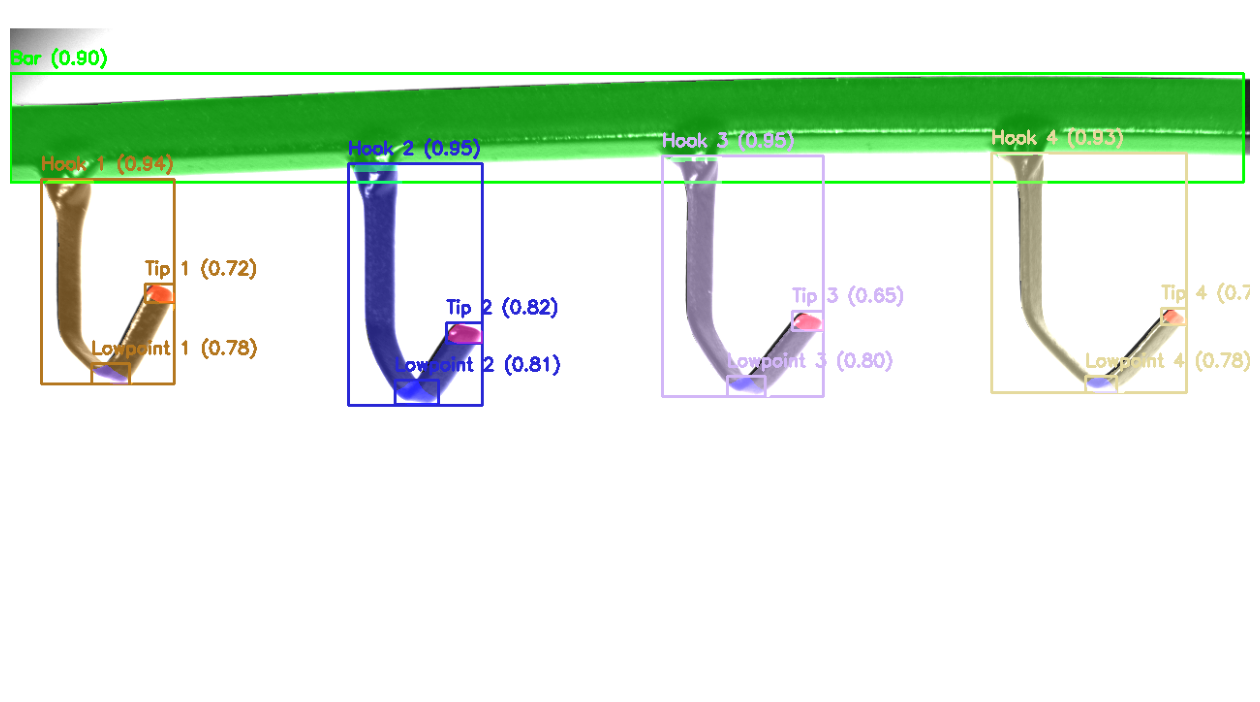

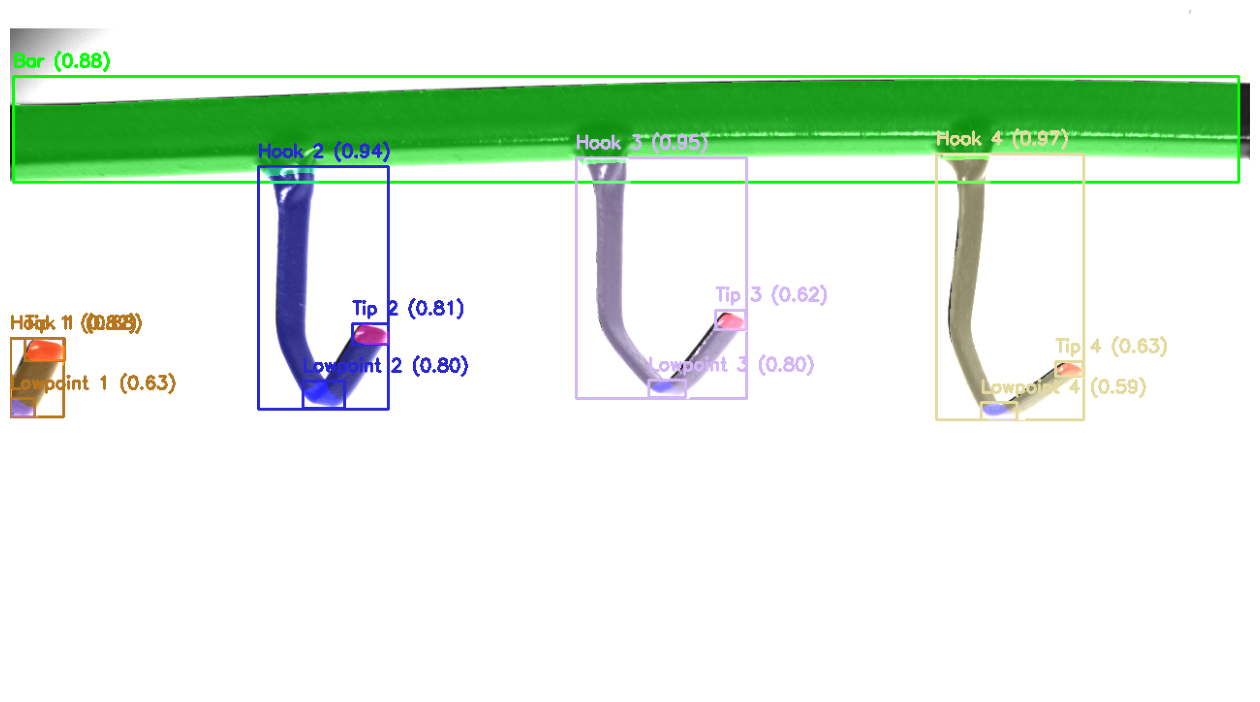

In [7]:
inp1_bar_dict, inp1_hooks_dict = yolov8_postprocessing.postprocess(results=out1, input=inp1, plot_result=True)
inp2_bar_dict, inp2_hooks_dict = yolov8_postprocessing.postprocess(results=out2, input=inp2, plot_result=True)

In [8]:
hook_inp1 = inp1_hooks_dict['hook_4']
hook_inp2 = inp2_hooks_dict['hook_3']

***
**Berechnung der Punkte über BBoxes**

In [9]:
def calc_midpoint_of_box(box):
    x1, y1, x2, y2 = box
    return [(x1+x2)/2, (y1+y2)/2]

In [10]:
hook_inp1['uv_hook_bb'] = calc_midpoint_of_box(hook_inp1['hook_box'])
hook_inp1['uv_tip_bb'] = calc_midpoint_of_box(hook_inp1['tip_box'])
hook_inp1['uv_lowpoint_bb'] = calc_midpoint_of_box(hook_inp1['lowpoint_box'])

hook_inp2['uv_hook_bb'] = calc_midpoint_of_box(hook_inp2['hook_box'])
hook_inp2['uv_tip_bb'] = calc_midpoint_of_box(hook_inp2['tip_box'])
hook_inp2['uv_lowpoint_bb'] = calc_midpoint_of_box(hook_inp2['lowpoint_box'])

print("Hook coordinates over Bboxes [px] in img 1:")
print(hook_inp1['uv_hook_bb'])
print(hook_inp1['uv_tip_bb'])
print(hook_inp1['uv_lowpoint_bb'])

print("\nHook coordinates over Bboxes [px] in img 2:")
print(hook_inp2['uv_hook_bb'])
print(hook_inp2['uv_tip_bb'])
print(hook_inp2['uv_lowpoint_bb'])

Hook coordinates over Bboxes [px] in img 1:
[1114.2825927734375, 271.7566223144531]
[1201.322998046875, 316.531005859375]
[1126.364013671875, 387.0030517578125]

Hook coordinates over Bboxes [px] in img 2:
[672.961669921875, 277.558837890625]
[744.3321533203125, 320.543212890625]
[678.778564453125, 391.5762634277344]


***
**Berechnung der Punkte über Momente der Segmentierung**

In [11]:
def calc_midpoint_with_meanpx(mask):
    startt = time.perf_counter()
    ys, xs = np.where(mask == 1)

    # Mittelwert der Koordinaten
    cx = np.mean(xs)
    cy = np.mean(ys)
    endt = time.perf_counter()
    #print(f"Time: {endt-startt} sec")
    return [cx, cy]

In [12]:
hook_inp1['uv_hook'] = calc_midpoint_with_meanpx(hook_inp1['hook_mask'])
hook_inp1['uv_tip'] = calc_midpoint_with_meanpx(hook_inp1['tip_mask'])
hook_inp1['uv_lowpoint'] = calc_midpoint_with_meanpx(hook_inp1['lowpoint_mask'])

hook_inp2['uv_hook'] = calc_midpoint_with_meanpx(hook_inp2['hook_mask'])
hook_inp2['uv_tip'] = calc_midpoint_with_meanpx(hook_inp2['tip_mask'])
hook_inp2['uv_lowpoint'] = calc_midpoint_with_meanpx(hook_inp2['lowpoint_mask'])

print("Hook coordinates [px] in img 1:")
print(hook_inp1['uv_hook'])
print(hook_inp1['uv_tip'])
print(hook_inp1['uv_lowpoint'])

print("\nHook coordinates [px] in img 2:")
print(hook_inp2['uv_hook'])
print(hook_inp2['uv_tip'])
print(hook_inp2['uv_lowpoint'])

Hook coordinates [px] in img 1:
[1093.6566862013851, 287.1545018646777]
[1202.6066666666666, 317.81666666666666]
[1125.6764705882354, 388.16577540106954]

Hook coordinates [px] in img 2:
[651.9929792147806, 291.4834180138568]
[745.5084337349398, 322.2289156626506]
[676.6498800959232, 392.77218225419665]


***
**Berechnung der Punkte über KMeans der Segmentierungsmasken**

In [13]:
def calc_midpoint_with_kmeans(mask):
    #startt = time.perf_counter()
    points = np.column_stack(np.where(mask == 1))
    kmeans = KMeans(n_init=10, n_clusters=1, random_state=0).fit(points)
    cx = kmeans.cluster_centers_[0][1]
    cy = kmeans.cluster_centers_[0][0]
    #endt = time.perf_counter()
    #print(f"Time: {endt-startt} sec")
    return [cx, cy]

In [14]:
hook_inp1['uv_hook_km'] = calc_midpoint_with_kmeans(hook_inp1['hook_mask'])
hook_inp1['uv_tip_km'] = calc_midpoint_with_kmeans(hook_inp1['tip_mask'])
hook_inp1['uv_lowpoint_km'] = calc_midpoint_with_kmeans(hook_inp1['lowpoint_mask'])

hook_inp2['uv_hook_km'] = calc_midpoint_with_kmeans(hook_inp2['hook_mask'])
hook_inp2['uv_tip_km'] = calc_midpoint_with_kmeans(hook_inp2['tip_mask'])
hook_inp2['uv_lowpoint_km'] = calc_midpoint_with_kmeans(hook_inp2['lowpoint_mask'])

print("Hook coordinates [px] in img 1:")
print(hook_inp1['uv_hook_km'])
print(hook_inp1['uv_tip_km'])
print(hook_inp1['uv_lowpoint_km'])

print("\nHook coordinates [px] in img 2:")
print(hook_inp2['uv_hook_km'])
print(hook_inp2['uv_tip_km'])
print(hook_inp2['uv_lowpoint_km'])

Hook coordinates [px] in img 1:
[1093.6566862013844, 287.1545018646776]
[1202.6066666666666, 317.81666666666666]
[1125.6764705882354, 388.1657754010695]

Hook coordinates [px] in img 2:
[651.99297921478, 291.48341801385743]
[745.5084337349398, 322.2289156626506]
[676.6498800959232, 392.77218225419665]


***
**Plot der Punkte**

In [15]:
def plot_points(img, hook_dict):
    img_copy = img.copy()
    bb_hook = tuple(map(int, hook_dict['hook_box']))

    p_hook = tuple(map(int, hook_dict['uv_hook']))
    p_tip = tuple(map(int, hook_dict['uv_tip']))
    p_lowpoint = tuple(map(int, hook_dict['uv_lowpoint']))

    p_hook_bb = tuple(map(int, hook_dict['uv_hook_bb']))
    p_tip_bb = tuple(map(int, hook_dict['uv_tip_bb']))
    p_lowpoint_bb = tuple(map(int, hook_dict['uv_lowpoint_bb']))

    p_hook_km = tuple(map(int, hook_dict['uv_hook_km']))
    p_tip_km = tuple(map(int, hook_dict['uv_tip_km']))
    p_lowpoint_km = tuple(map(int, hook_dict['uv_lowpoint_km']))

    cv2.rectangle(img_copy, (bb_hook[0], bb_hook[1]), (bb_hook[2], bb_hook[3]), (150, 150, 150), 2)

    cv2.drawMarker(img_copy, p_hook, color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=2, line_type=cv2.LINE_AA)
    cv2.drawMarker(img_copy, p_tip, color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=2, line_type=cv2.LINE_AA)
    cv2.drawMarker(img_copy, p_lowpoint, color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=2, line_type=cv2.LINE_AA)

    cv2.drawMarker(img_copy, p_hook_bb, color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=2, line_type=cv2.LINE_AA)
    cv2.drawMarker(img_copy, p_tip_bb, color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=2, line_type=cv2.LINE_AA)
    cv2.drawMarker(img_copy, p_lowpoint_bb, color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=2, line_type=cv2.LINE_AA)

    #cv2.drawMarker(img_copy, p_hook_km, color=(0, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=2, line_type=cv2.LINE_AA)
    #cv2.drawMarker(img_copy, p_tip_km, color=(0, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=2, line_type=cv2.LINE_AA)
    #cv2.drawMarker(img_copy, p_lowpoint_km, color=(0, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=2, line_type=cv2.LINE_AA)

    plt.figure(figsize=(16, 16))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

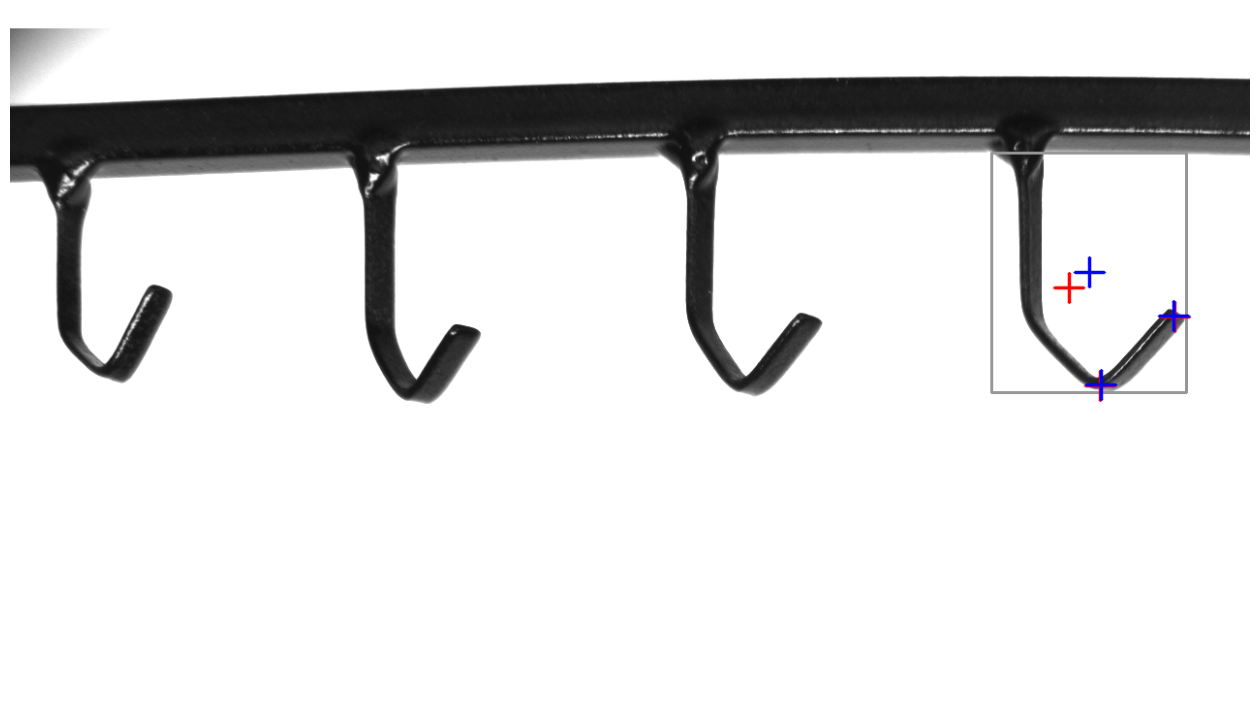

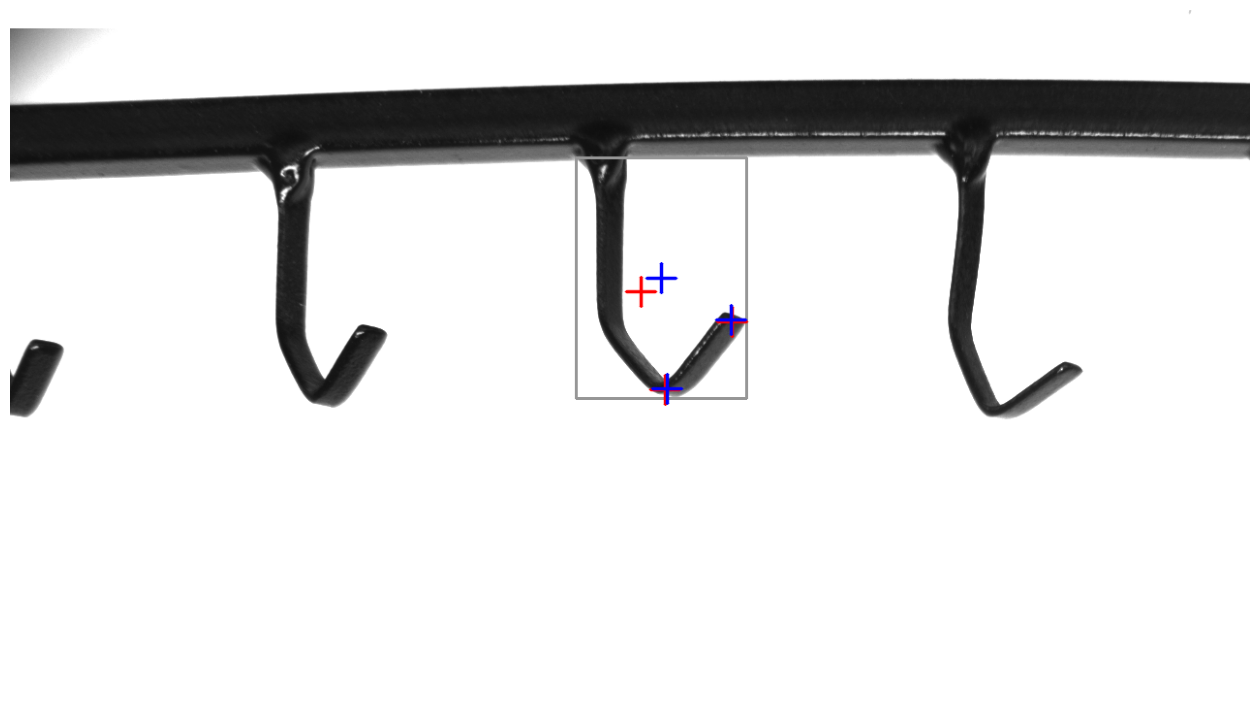

In [16]:
plot_points(inp1, hook_inp1)
plot_points(inp2, hook_inp2)

***
**Projektionsmatrix (Intrinsik, Extrinsik)**

In [27]:
f_x = 0.006/3.45e-6
f_y = 0.006/3.45e-6
c_x = 1536/2     #720/2
c_y = 2048/2     #1280/2

intrinsics = [[f_x, 0, c_x], 
              [0, f_y, c_y], 
              [0, 0, 1]]

In [28]:
calib_data = np.load('/home/mo/Thesis/calibration_data.npz')
mtx = calib_data['mtx']  # Kameramatrix
dist = calib_data['dist']  # Verzerrungskoeffizienten
rvecs = calib_data['rvecs']  # Rotationsvektoren
tvecs = calib_data['tvecs']  # Translationsvektoren

In [29]:
# intrinsics = mtx

In [30]:
def calc_extrinsics(angle_x = 0, angle_y = 0, angle_z = 0, t_x = 0, t_y = 0, t_z = 0):
    t = np.array([[t_x, t_y, t_z]])

    R_x = np.array([[1, 0, 0],
           [0, np.cos(angle_x), -np.sin(angle_x)],
           [0, np.sin(angle_x), np.cos(angle_x)]])

    R_y = np.array([[np.cos(angle_y), 0, np.sin(angle_y)],
           [0, 1, 0],
           [-np.sin(angle_y), 0, np.cos(angle_y)]])

    R_z = np.array([[np.cos(angle_z), -np.sin(angle_z), 0],
           [np.sin(angle_z), np.cos(angle_z), 0],
           [0, 0, 1]])

    R = R_x @ (R_y @ R_z)
    return np.hstack((R, t.T))

In [31]:
def calc_projection_matrix(intrinsics, extrinsics):
    return intrinsics @ extrinsics

In [32]:
proj1 = calc_projection_matrix(intrinsics, calc_extrinsics(0, 0, 0, 0, 0, 0))
proj2 = calc_projection_matrix(intrinsics, calc_extrinsics(0, 0, 0, 50, 0, 0))

***
**Stereo Triangulation**

In [33]:
points1 = np.array([hook_inp1['uv_hook'],
                    hook_inp1['uv_tip'],
                    hook_inp1['uv_lowpoint']], dtype=np.float64).T

points2 = np.array([hook_inp2['uv_hook'],
                    hook_inp2['uv_tip'],
                    hook_inp2['uv_lowpoint']], dtype=np.float64).T

In [34]:
# points1 = cv2.undistortPoints(points1, mtx, dist, None, mtx)
# points2 = cv2.undistortPoints(points2, mtx, dist, None, mtx)

In [35]:
points4D_hom = cv2.triangulatePoints(proj1, proj2, points1, points2)
points3D = points4D_hom[:3] / points4D_hom[3]

In [36]:
hook_xyz = points3D[:, 0]
tip_xyz = points3D[:, 1]
lowpoint_xyz = points3D[:, 2]

print(f"Coordinates of hook: {hook_xyz} mm")
print(f"Coordinates of tip: {tip_xyz} mm")
print(f"Coordinates of lowpoint: {lowpoint_xyz} mm")

Coordinates of hook: [    -36.867      83.172     -196.88] mm
Coordinates of tip: [     -47.54      77.005     -190.24] mm
Coordinates of lowpoint: [    -39.828      70.545     -193.66] mm
